In [15]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [16]:
#digits dataset for input samples
def extract_dataset(f):
    data = []
    for line in f:
        if (line.split()[0] == "1.0000"):
            data.append(line.split())
        elif(line.split()[0] == "5.0000"):
            data.append(line.split())

    #changing the values of 5.0000 to -1 and 1.0000 the value of 1
    df = pd.DataFrame(data)
    df[0] = df[0].replace(["1.0000","5.0000"],[1,-1])
    
    for col in df.columns:
        df[col] = df[col].astype(float)

    features, rows, cols = extract_features(df)
    
    return features, rows, cols, df[0].astype(int)

def extract_features(df):
    rows, cols = df.shape
    features = np.zeros(shape = (rows,3))
    
    df1 = df.copy()
    df1 = df1.drop(0,axis=1)
    
    #extracting the intensity from the dataset
    for i in range(rows):
        mean_int = df1.loc[i,0:255].mean()
        features[i][0] = 1
        features[i][1] = mean_int
    

    flipped_df = df.loc[:, :1:-1]
    flipped_df.columns = df1.columns
    diff = pd.DataFrame()
    diff = abs(df1.subtract(flipped_df))
    
    #extracting the symmetry from the dataset
    for i in range(rows):
        mean_sym = diff.loc[i,0:255].mean()
        features[i][0] = 1
        features[i][2] =  mean_sym*-1

    return features, rows, cols

In [17]:
# computing the signals for every layer
def signal(weights, input_vector):
    signal = weights[0]
    signal += np.dot(weights[1::], input_vector[1::])
    return signal

# transformation function
def transformation_function(signal):
    return np.tanh(signal)
           
#Forward Propagation
def forward_propagate(network_weights, input_vector):
    network_inputs = [input_vector]
    for layer in network_weights:
        new_inputs = []
        for neuron in layer:
            s = signal(neuron, input_vector)
            out = transformation_function(s)
            new_inputs.append(out)
        input_vector = np.concatenate(([1],np.array(new_inputs)))
        network_inputs.append(np.array(input_vector))
     
    return np.array(new_inputs),np.array(network_inputs)

In [18]:
# computing theta'
def activation_derivative(output):
    return np.fromiter([(1 - output[i]**2) for i in range(1, len(output))], float)

def back_propagate(network_layers, network_inputs, network_weights, y_true, y_pred):
    delta = np.empty_like(network_weights)
    for i,j in zip(range(len(network_weights)-1,-1,-1), range(len(network_inputs)-1,-1,-1)):
        if(i == network_layers-1):
            theta_dash =  activation_derivative(network_inputs[j])
            error = np.array(y_pred[1::] - y_true[1::])
            delta[i] = np.array([2 * error.dot(theta_dash)])
        
        else:
            for neuron in network_weights[i+1]:
                theta_dash =  activation_derivative(network_inputs[j])
                w,b = neuron[1:],neuron[0]
                error_mul = w.reshape(len(w),1).dot(delta[-1])
                delt_mul = error_mul * theta_dash
            delta[i] = delt_mul
            
    return delta

In [19]:
def compute_gradient(n_inputs, network_layers, network_inputs, y_true, y_pred, delta):
    
    gradient = list()
    for i in range(1, len(network_inputs)):
        delt = delta[i].reshape(len(delta[i]),1)
        outs = network_inputs[i-1].reshape(len(network_inputs[i-1]),1)
        gradient.append(delt.dot(outs.transpose()))
    
    return np.array(gradient)

In [20]:
def update_weights(n_layers, network_weights, network_inputs, delta, record, l_rate, single_point_gradient):
    for i in range(1, n_layers):
        for j in range(len(network_weights[i-1])): 
            network_weights[i-1][j] = network_weights[i-1][j] - (l_rate * single_point_gradient[i-1][j])
    return network_weights

In [21]:
def plot_error(iters, errors):
    fig, ax = plt.subplots(figsize=(15,10))
    plt.title("Ein | Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Ein")
    ax.plot(iters, errors)
    plt.show

In [22]:
def predict(network_weights, test_features, y_true):

    misclassified_points = 0
    for index in range(len(test_features)):
        inputs = np.array([1, test_features[index][1], test_features[index][2]])
        expected = [None, y_true[index]]

        #forward propagate
        actual, outputs = forward_propagate(network_weights, inputs)
        actual = [None]+[i for i in actual]
        
        if(np.sign(actual[1]) != expected[1]):
            misclassified_points += 1
                
    # test error
    error = misclassified_points/len(test_features)
    
    return error

In [23]:
# vanilla gradient descent
def vanilla_gradient(l_rate, n_layers, network_weights, features, y_true, total_iterations):
    
    it = 0
    iters = []
    errors = []
    n_epochs = math.floor(total_iterations / len(features))
    
    for epoch in range(n_epochs):
        error = 0
        misclassified_points = 0
        overall_gradient = np.zeros_like((network_weights))
        for i in range(len(features)):
            inputs = np.array([1, features[i][1], features[i][2]])
            expected = [None, y_true.loc[i]]
            
            #forward propagate
            actual, outputs = forward_propagate(network_weights, inputs)
            actual = [None]+[i for i in actual]
            
            if np.sign(actual[1]) != np.sign(expected[1]):
                misclassified_points += 1
            
            # back propagate
            delta = back_propagate(n_layers, outputs, network_weights, np.array(expected), np.array(actual)) 
            delta = [None]+[i for i in delta]
            
            single_point_gradient = compute_gradient(n_inputs, n_layers, outputs, expected, actual, np.array(delta))
            overall_gradient = overall_gradient + (1/len(features)) * single_point_gradient
        
        error = misclassified_points/len(features)
        it = it + 1
        iters.append(it)
        errors.append(error)
        
        # update the weights
        network_weights = update_weights(n_layers, network_weights, outputs, delta, features[i], l_rate, overall_gradient)    
            
    print('Epoch=%d, Learning rate=%.3f, In-sample error=%.3f' % (epoch, l_rate, error))
    plot_error(iters, errors)
    
    return network_weights

In [24]:
# mini-batch gradient descent
def mini_batch_gradient(l_rate, n_layers, network_weights, features, y_true, batch_size, total_iterations):
    
    it = 0
    iters = []
    errors = []
    n_epochs = math.floor(total_iterations / len(features))
    iter_per_epoch = math.floor(len(features) / batch_size)
    
    for epoch in range(n_epochs):
        index = np.arange(1561)
        overall_gradient = np.zeros_like((network_weights))
#         np.random.shuffle(features)
        
        for itr in range(iter_per_epoch):     
            if len(index) == 0:
                break
            batch_index = np.random.choice(index, batch_size, replace=False)
            index = list(set(index) - set(batch_index))
            
            batch_features = [features[idx] for idx in batch_index]
            batch_expected = [y_true[idx] for idx in batch_index]
            misclassified_points = 0
            
            for i in range(len(batch_features)):
                inputs = np.array([1, batch_features[i][1], batch_features[i][2]])
                expected = [None, batch_expected[i]]
                
                #forward propagate
                actual, outputs = forward_propagate(network_weights, inputs)
                actual = [None]+[i for i in actual]
                
                # back propagate
                delta = back_propagate(n_layers, outputs, network_weights, np.array(expected), np.array(actual)) 
                delta = [None]+[i for i in delta]
                
                single_point_gradient = compute_gradient(n_inputs, n_layers, outputs, expected, actual, np.array(delta))
                overall_gradient = overall_gradient + (1/len(batch_features)) * single_point_gradient

            # update the weights
            network_weights = update_weights(n_layers, network_weights, outputs, delta, batch_features[i], l_rate, overall_gradient) 

        # in-sample error
        rand_index = np.arange(1561)
        sub_idx = np.random.choice(rand_index, 1000, replace=False)
        rand_inputs = [features[idx] for idx in sub_idx]
        rand_expected = [y_true[idx] for idx in sub_idx]

        error = predict(network_weights, rand_inputs, rand_expected)
        it += 1
        iters.append(it)
        errors.append(error)
            
    print('Epoch=%d, Learning rate=%.3f, In-sample error=%.3f' % (epoch, l_rate, error))
    plot_error(iters, errors)
    
    return network_weights

In [25]:
# stochastic gradient descent
def stochastic_gradient_descent(l_rate, n_layers, network_weights, features, y_true, total_iterations):
    
    it = 0
    iters = []
    errors = []
    n_epochs = math.floor(total_iterations/len(features))
    index = np.arange(1561)
    for epoch in range(n_epochs):
        misclassified_points = 0
#         np.random.shuffle(features)
        overall_gradient = np.zeros_like((network_weights))
        error = 0
        for i in range(len(features)):
            inputs = np.array([1, features[i][1], features[i][2]])
            expected = [None, y_true.loc[i]]
            
            #forward propagate
            actual, outputs = forward_propagate(network_weights, inputs)
            actual = [None]+[i for i in actual]
            
            # back propagate
            delta = back_propagate(n_layers, outputs, network_weights, np.array(expected), np.array(actual)) 
            delta = [None]+[i for i in delta]
            single_point_gradient = compute_gradient(n_inputs, n_layers, outputs, expected, actual, np.array(delta))

            # update the weights
            network_weights = update_weights(n_layers, network_weights, outputs, delta, features[i], l_rate, single_point_gradient)
            
            if i%1000 == 0:
                batch_index = np.random.choice(index, 1000, replace=False)
                batch_features = [features[idx] for idx in batch_index]
                batch_expected = [y_true[idx] for idx in batch_index]

                error = predict(network_weights, batch_features, batch_expected)
            
                it += 1
                iters.append(it)
                errors.append(error)
        
    print('Epoch=%d, Learning rate=%.3f, In-sample error=%.3f' % (epoch, l_rate, error))
    plot_error(iters, errors)
    
    return network_weights

In [26]:
    f_train = open("/Users/bharathi/Documents/Digits/ZipDigits.train", "r")
    train_features, rows, cols, train_y_true = extract_dataset(f_train)

    f_test = open("/Users/bharathi/Documents/Digits/ZipDigits.test", "r")
    test_features, test_rows, test_cols, test_y_true = extract_dataset(f_test)

#### Network setup

In [35]:
def network_setup():
    n_inputs= 2
    n_layers = 2
    hidden_units = 5

    np.random.seed(1)

    hidden_layer = np.random.rand(hidden_units, n_inputs + 1)
    output_layer = np.random.rand(1,hidden_units+1)
    network_weights = np.array((hidden_layer,output_layer))

    return network_weights, n_layers, n_inputs

### (5.1) Vanilla Gradient Descent

Epoch=1280, Learning rate=0.010, In-sample error=0.034


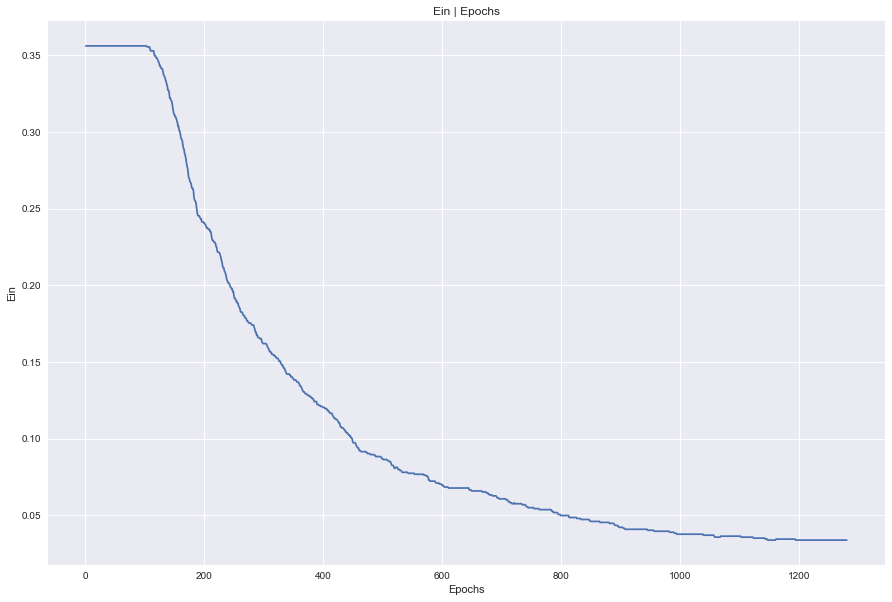

In [36]:
l_rate = 0.01
batch_size = len(train_features)
total_iterations = 2000000

network_weights, n_layers, n_inputs = network_setup()

batch_network_weights = vanilla_gradient(l_rate, n_layers, network_weights, train_features, train_y_true, total_iterations)

In [37]:
batch_test_error = predict(batch_network_weights, test_features, test_y_true)
print("Vanilla gradient descent - Test error = ", batch_test_error)

Vanilla gradient descent - Test error =  0.049528301886792456


### (5.2) Stochastic Gradient Descent

Epoch=1280, Learning rate=0.010, In-sample error=0.024


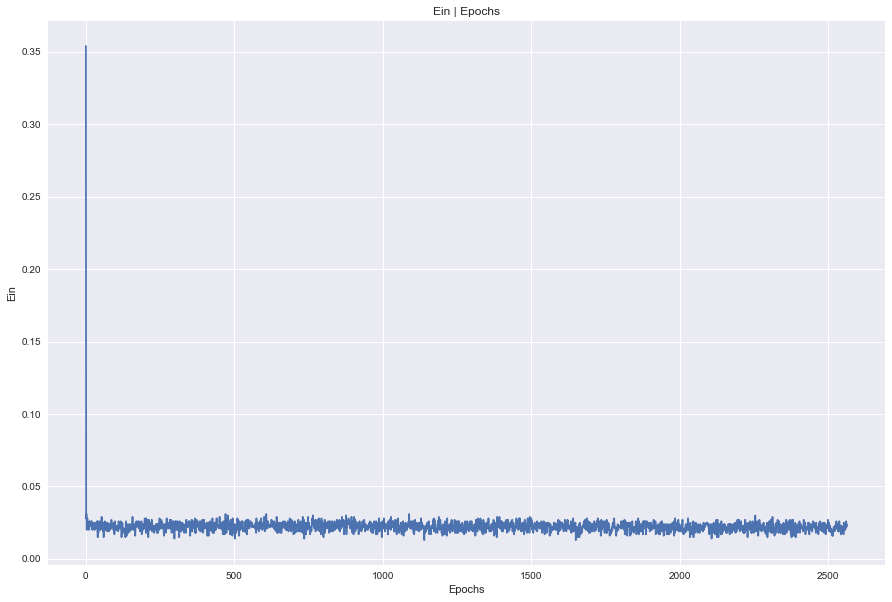

In [38]:
l_rate = 0.01
total_iterations = 2000000

network_weights, n_layers, n_inputs = network_setup()

sgd_network_weights = stochastic_gradient_descent(l_rate, n_layers, network_weights, train_features, train_y_true, total_iterations)

In [39]:
sgd_test_error = predict(sgd_network_weights, test_features, test_y_true)
print("Stochastic gradient descent - Test error = ", sgd_test_error)

Stochastic gradient descent - Test error =  0.04716981132075472


### (5.3) Mini-batch Gradient Descent

Epoch=1280, Learning rate=0.010, In-sample error=0.022


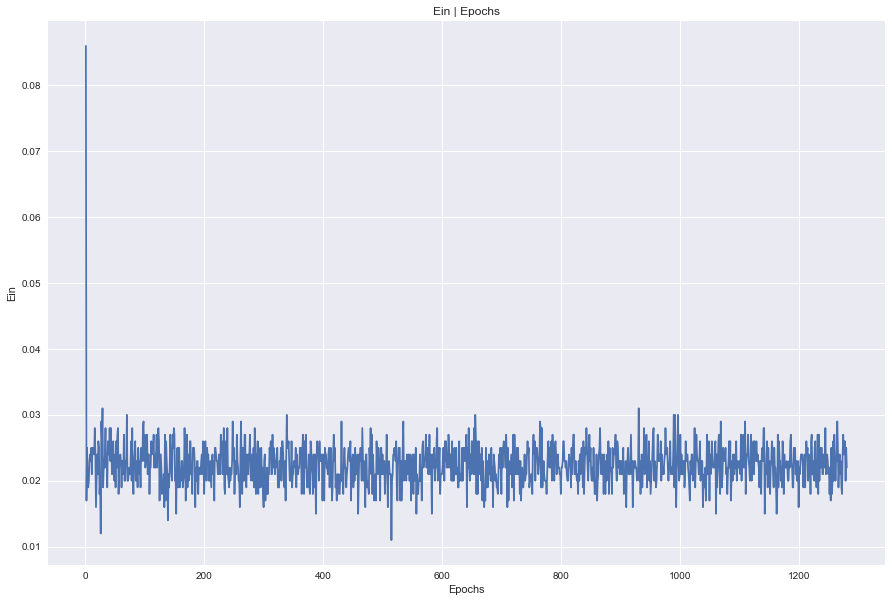

In [40]:
l_rate = 0.01
batch_size = 32
total_iterations = 2000000

network_weights, n_layers, n_inputs = network_setup()
mini_network_weights = mini_batch_gradient(l_rate, n_layers, network_weights, train_features, train_y_true, batch_size, total_iterations)

In [41]:
mini_test_error = predict(mini_network_weights, test_features, test_y_true)
print("Mini-batch gradient descent (SGD) - Test error = ", mini_test_error)

Mini-batch gradient descent (SGD) - Test error =  0.04481132075471698
